# README
This is a simple cleaner of data for the tweets that we have collected and classified. We are trying to get two key things:

- Classification
- Tweet itself

In order to do this we will see what we can do with pandas.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Chicago4C and UC-Irvine
old_cat = pd.read_csv('categorized_tweets.csv', encoding = "ISO-8859-1")
old_cat = old_cat[['Category', 'Tweet']]

In [3]:
# Boston
bos_tweets = pd.read_csv('twitter-data-4c/Boston4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
bos_tweets = bos_tweets[[2, 1]]
bos_tweets.columns = ['Category', 'Tweet']

# Brisbane
bris_tweets = pd.read_csv('twitter-data-4c/Brisbane4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
bris_tweets = bris_tweets[[2, 1]]
bris_tweets.columns = ['Category', 'Tweet']

# Dublin
dub_tweets = pd.read_csv('twitter-data-4c/Dublin4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
dub_tweets = dub_tweets[[2, 1]]
dub_tweets.columns = ['Category', 'Tweet']

# London
lon_tweets = pd.read_csv('twitter-data-4c/London4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
lon_tweets = lon_tweets[[2, 1]]
lon_tweets.columns = ['Category', 'Tweet']

# Memphis
mem_tweets = pd.read_csv('twitter-data-4c/Memphis4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
mem_tweets = mem_tweets[[2, 1]]
mem_tweets.columns = ['Category', 'Tweet']

# New York City
nyc_tweets = pd.read_csv('twitter-data-4c/NYC4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
nyc_tweets = nyc_tweets[[2, 1]]
nyc_tweets.columns = ['Category', 'Tweet']

# Seattle
sea_tweets = pd.read_csv('twitter-data-4c/Seattle4Classes.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
sea_tweets = sea_tweets[[2, 1]]
sea_tweets.columns = ['Category', 'Tweet']

# Sydney
syd_tweets = pd.read_csv('twitter-data-4c/Sydney4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
syd_tweets = syd_tweets[[2, 1]]
syd_tweets.columns = ['Category', 'Tweet']

In [4]:
# New tweets pulled by Henry
#chi_geo = pd.read_csv('fire-dept-geocode.csv', encoding = "ISO-8859-1", delimiter = ',')
pulled_fire_related = pd.read_csv('fire-dept.csv', encoding = "ISO-8859-1")
pulled_fire_related = pulled_fire_related[['category', 'text']]
pulled_fire_related.columns = ['Category', 'Tweet']

In [5]:
# Creating 1 dataframe and making it a csv
tweet_list = list([old_cat, bos_tweets, bris_tweets, dub_tweets, lon_tweets, mem_tweets, nyc_tweets,
             sea_tweets, syd_tweets, pulled_fire_related])

df = pd.concat(tweet_list).reset_index()
df = df[['Category', 'Tweet']]
df.Category = df.Category.str.upper()
df = df[(df.Category == 'FIRE') | (df.Category == 'NO')].reset_index()
df = df[['Category', 'Tweet']]

In [6]:
]col = ["Category", "Tweet"]
df = df[col]
df.columns = ['Category', 'Tweet']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Tweet,category_id
0,FIRE,Firefighters battle a two-alarm blaze at 54 Ma...,0
1,FIRE,Pray for Fort McMurray \n#forrestfire #cl415 #...,0
2,FIRE,Addison and McGraw. E42X stretched. #fourthofj...,0
3,FIRE,With fire season starting my brother is a hots...,0
4,FIRE,These Forrest fires are OUT OF CONTROL! ðð...,0


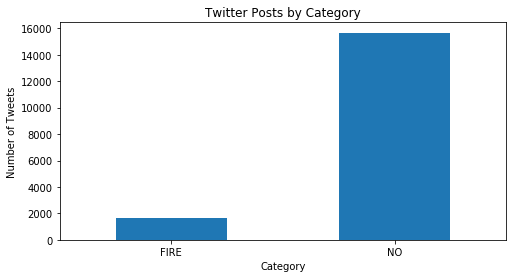

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
df.groupby('Category').Tweet.count().plot.bar(ylim=0)
plt.ylabel('Number of Tweets')
plt.title('Twitter Posts by Category')
plt.xticks(rotation = 0)
plt.rcParams.update({'font.size': 9})
plt.savefig('tweets_by_category.jpg')
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Tweet).toarray()
labels = df.category_id
features.shape

(17298, 7673)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
X = df.Tweet
y = df.Category

count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

# Creating the stratified training and test sets
for train_index, test_index in split.split(X_vect, y):
    X_train, X_test = X_vect[train_index], X_vect[test_index]
    y_train, y_test = y[train_index], y[test_index]

`CountVectorizer()` implements both tokenization and occurrence counting in a single class. We give each word its own integer representation and count how many times a token occurs.

Many words are not important in the analysis of text. A `TfidfTransformer()` reweights the words/tokens in the vectorized tweets. "Tf" means term-frequency and "idf" means inverse document frequency.

${tfidf}(t,d) = {tf}(t,d) * {idf}(t)$

The term frequency, the number of times a term occurs in a given document, is multiplied with idf component, which is computed as:

${idf}(t) = log \frac{1+n}{1+{df}(t)} + 1$

where where $n$ is the total number of documents in the document set, and $df(t)$ is the number of documents in the document set that contain term. The resulting tf-idf vectors are then normalized by the Euclidean norm:

$v_{norm} = \frac{\mathbf{v}}{{||\mathbf{v}||}_2}$

We did use Tf-Idf correction for smoothing, which adds “1” to the numerator and denominator as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions:

In [12]:
# Defaults: TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False) 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_train_tfidf[0])

  (0, 32156)	0.5054438738537189
  (0, 31791)	0.15684855430650183
  (0, 27262)	0.2304659627633743
  (0, 16046)	0.41923934791083695
  (0, 14421)	0.527161348731629
  (0, 11109)	0.20815548148998772
  (0, 6640)	0.4120934827143895


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Previous Work
First we will try the model with our defaults:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 42),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.905808
1,RandomForestClassifier,1,0.905780
2,RandomForestClassifier,2,0.906042
3,RandomForestClassifier,3,0.906042
4,RandomForestClassifier,4,0.906042
5,LinearSVC,0,0.941635
6,LinearSVC,1,0.938728
7,LinearSVC,2,0.945071
8,LinearSVC,3,0.967042
9,LinearSVC,4,0.942469


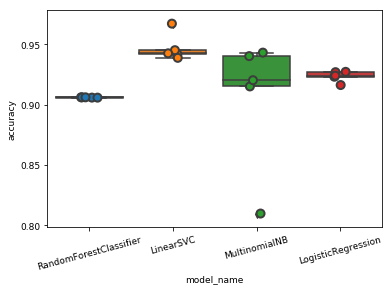

In [15]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.figure(figsize=(20,20))
plt.rcParams["figure.figsize"] = [10,10]
plt.xticks(rotation = 15)
plt.rcParams.update({'font.size': 14})
plt.savefig('results_large_text.png')
plt.show()

# Playing with the Random Forest

In [16]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf_vect = TfidfVectorizer()

In [17]:
param_distribs = {
        'n_estimators': np.linspace(100, 500, num = 5).astype(int),
        'max_depth': np.linspace(1, 5, num = 5).astype(int),
        'max_features': np.linspace(1, 10, num = 10).astype(int)
    }

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid=param_distribs, 
                           cv=5, scoring=None)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([100, 200, 300, 400, 500]), 'max_depth': array([1, 2, 3, 4, 5]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
{'max_depth': 1, 'max_features': 1, 'n_estimators': 100}


In [21]:
# Fitting the best grid searched random forest 
from sklearn.metrics import accuracy_score

brf_clf = RandomForestClassifier(max_depth = 1, max_features = 1, n_estimators = 100, random_state = 42)
brf_clf.fit(X_train_tfidf, y_train)
y_pred_rf = brf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9060693641618497

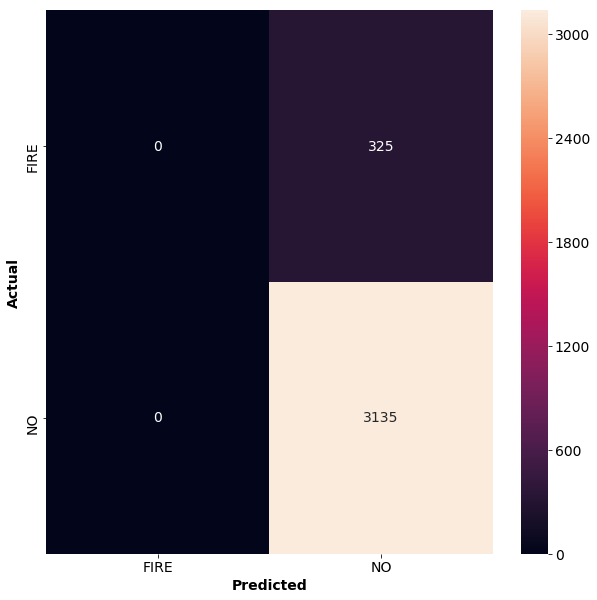

In [22]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual', fontweight = 'bold')
plt.xlabel('Predicted', fontweight = 'bold')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.savefig('rf_confusion.png')
plt.show()

This is not good for results. It's **really** bad overfitting towards the `NO` class.

**Why is this a wash?** Investigate later.

*Potential solution:* Try a gradient boosting classifier, page 200 in Geron ML book and link: 

`https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html`

In [38]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_rf, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.00      0.00      0.00       325
          NO       0.91      1.00      0.95      3135

   micro avg       0.91      0.91      0.91      3460
   macro avg       0.45      0.50      0.48      3460
weighted avg       0.82      0.91      0.86      3460



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# SVC
Will this be a better binary classifier? 

**Answer:** Yes, however, we are going to try different kernel tricks.

In [31]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

param_distribs = {
        'C': [1, 10, 100, 1000],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [1, 2, 3, 4, 5],
        'coef0': [0, 10, 100]
    }

svc_clf = SVC(gamma = 'auto', random_state = 42, max_iter = 10000)
grid_search = GridSearchCV(svc_clf, param_grid=param_distribs,
                                cv=5, scoring=None)
grid_search.fit(X_train_tfidf, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-pa

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3, 4, 5], 'coef0': [0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
print(grid_search.best_estimator_,
     grid_search.best_params_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='linear',
  max_iter=10000, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False) {'C': 10, 'coef0': 0, 'degree': 1, 'kernel': 'linear'}


In [34]:
bsvc_clf = SVC(C = 10, kernel = 'linear', degree = 1, coef0 = 0, random_state = 42, max_iter = 100000)
bsvc_clf.fit(X_train_tfidf, y_train)
y_pred_svc = bsvc_clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred_svc)

0.9820809248554914

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


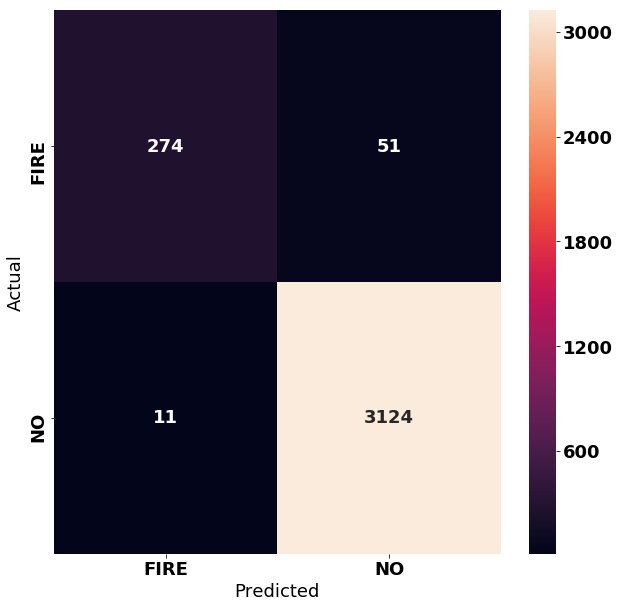

In [35]:
conf_mat = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.savefig('svc_confusion.png')
plt.show()

In [39]:
print(metrics.classification_report(y_test, y_pred_svc, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.96      0.84      0.90       325
          NO       0.98      1.00      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.97      0.92      0.94      3460
weighted avg       0.98      0.98      0.98      3460



# Logistic Classifier
Give this a try:

In [40]:
param_distribs = {
        'C': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'penalty': ['l1', 'l2']
    }

# Could potentially change penalty : str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’, optional (default=’l2’)

log_clf = LogisticRegression(random_state=42, max_iter = 1000)
grid_search = GridSearchCV(log_clf, param_grid=param_distribs,
                           cv=5, scoring=None)
grid_search.fit(X_train_tfidf, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations."

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
print(grid_search.best_estimator_, grid_search.best_params_)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) {'C': 20, 'penalty': 'l1'}


In [43]:
blog_clf = LogisticRegression(C = 20, penalty = 'l1', random_state = 42, max_iter = 1000)
blog_clf.fit(X_train_tfidf, y_train)
y_pred_log = blog_clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred_log)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9786127167630058

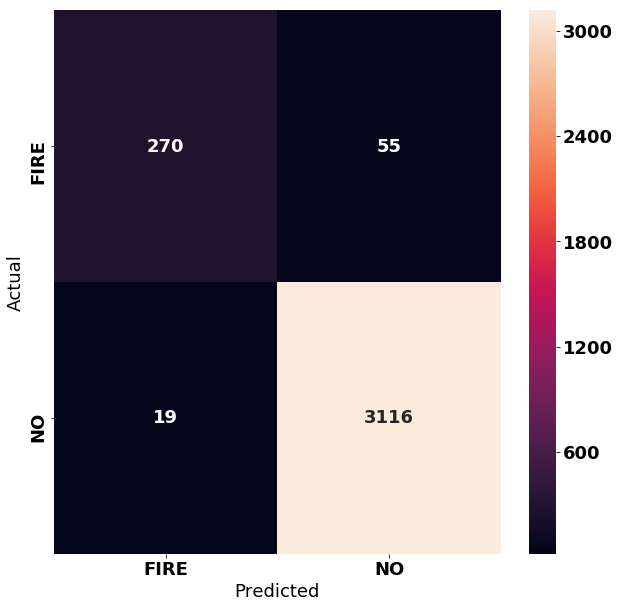

In [44]:
conf_mat = confusion_matrix(y_test, y_pred_log)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('log_confusion.png')
plt.show()

In [45]:
print(metrics.classification_report(y_test, y_pred_log, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.93      0.83      0.88       325
          NO       0.98      0.99      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.96      0.91      0.93      3460
weighted avg       0.98      0.98      0.98      3460



# Multinomial Bayes
Last one:

In [47]:
param_distribs = {
        'alpha': np.linspace(1, 50, num = 50).astype(int),
    }
mnb_clf = MultinomialNB()
grid_search = GridSearchCV(mnb_clf, param_grid=param_distribs,
                           cv=5, scoring=None)
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
print(grid_search.best_estimator_,
     grid_search.best_params_)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True) {'alpha': 1}


In [50]:
# The default value was choosen
bmnb_clf = MultinomialNB(alpha = 1)
bmnb_clf.fit(X_train_tfidf, y_train)
y_pred_nb = blog_clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred_nb)

0.9786127167630058

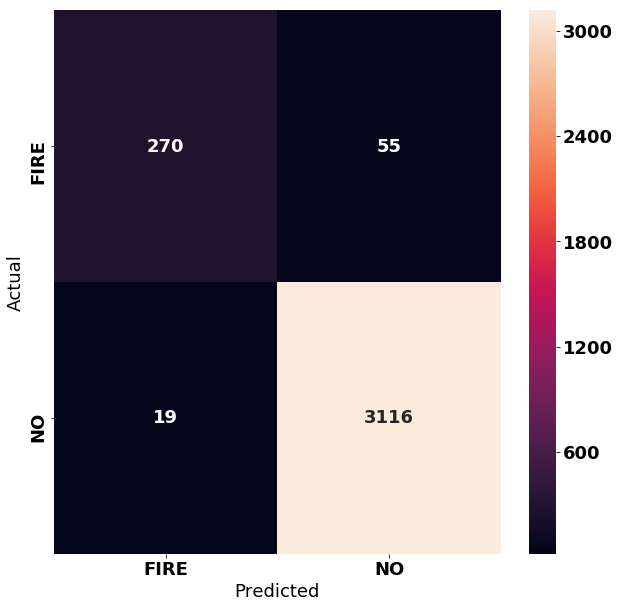

In [51]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig('mnb_confusion.png')
plt.show()

In [52]:
print(metrics.classification_report(y_test, y_pred_nb, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.93      0.83      0.88       325
          NO       0.98      0.99      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.96      0.91      0.93      3460
weighted avg       0.98      0.98      0.98      3460



# Building an Ensemble Learner

In [55]:
from sklearn.ensemble import VotingClassifier

bmnb_clf = MultinomialNB(alpha = 1)

voting_clf = VotingClassifier(
    estimators = [('lr', blog_clf), ('mnb', bmnb_clf), ('svc', bsvc_clf)],
    voting = 'hard')

for clf in (blog_clf, bsvc_clf, bmnb_clf, voting_clf):
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression 0.9786127167630058
SVC 0.9820809248554914
MultinomialNB 0.9199421965317919


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier 0.9797687861271677


In [57]:
y_pred = voting_clf.predict(X_test_tfidf)

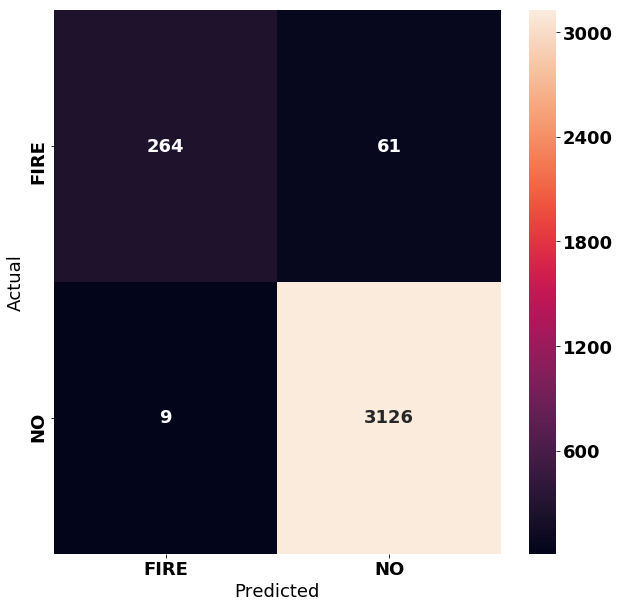

In [58]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.savefig('voting_confusion.png')
plt.show()

In [59]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.97      0.81      0.88       325
          NO       0.98      1.00      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.97      0.90      0.94      3460
weighted avg       0.98      0.98      0.98      3460



Looking into dimensionality reduction. Could be extremely useful in improving the cost of the algorithm in terms of time, and reduce the dimensionality of the problem at hand.